In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import wilcoxon, shapiro, ranksums
from jmetal.core.algorithm import Algorithm
from jmetal.core.quality_indicator import *
from jmetal.util.solution import print_function_values_to_file, print_variables_to_file, read_solutions

In [4]:
def generate_summary_from_experiment(input_dir, quality_indicators, summary_filename,
                                     reference_fronts = ''):
    reference_change = 2500
    
    if not quality_indicators:
        quality_indicators = []

    with open(summary_filename, "w+") as of:
        of.write("Algorithm,Problem,ExecutionId,IndicatorName,IndicatorValue\n")

    for dirname, _, filenames in os.walk(input_dir):
        for filename in filenames:
            try:
                # Linux filesystem
                algorithm, problem = dirname.split("/")[-2:]
            except ValueError:
                # Windows filesystem
                algorithm, problem = dirname.split("\\")[-2:]

            if "FUN" in filename:
                solutions = read_solutions(os.path.join(dirname, filename))
                run_tag = [s for s in filename.split(".") if s.isdigit()].pop()
                for indicator in quality_indicators:
                    reference_front_file = os.path.join(reference_fronts, problem + ".pf")

                    # Add reference front if any
                    if hasattr(indicator, "reference_front"):
                        if Path(reference_front_file).is_file():
                            reference_front = []
                            with open(reference_front_file) as file:
                                for line in file:
                                    reference_front.append([float(x) for x in line.split()])

                            indicator.reference_front = reference_front
                        else:
                            logger.warning("Reference front not found at", reference_front_file)

                    result = indicator.compute([solutions[i].objectives for i in range(len(solutions))])

                    # Save quality indicator value to file
                    with open(summary_filename, "a+") as of:
                        of.write(",".join([algorithm, problem, run_tag, indicator.get_short_name(), str(result)]))
                        of.write("\n")

In [13]:
filename = "summary-100k.csv"
datapath = "data-normals-100k"

In [14]:
generate_summary_from_experiment("data/{}".format(datapath), [InvertedGenerationalDistance(None)], filename,
                                "resources/reference_front")

In [143]:
df_100k = pd.read_csv("summary-100k.csv")
df_300k = pd.read_csv("summary-300k.csv")

df_smac_100k = pd.read_csv("summary-smac-100k.csv")
df_smac_300k = pd.read_csv("summary-smac-300k.csv")

In [145]:
algorithms = df_100k["Algorithm"].unique()
problems = df_100k["Problem"].unique()

In [146]:
problems_cat1 = ["ZDT1", "ZDT2", "ZDT3", "ZDT4", "ZDT6"]
problems_cat2 = ["UF1", "UF2", "UF3", "LZ09_F1", "LZ09_F2", "LZ09_F3", "LZ09_F4", "LZ09_F5"]
problems_cat3 = ["UF4", "UF8", "UF10", "WFG4", "WFG5", "WFG6", "WFG7", "WFG8", "WFG9", 
                 "DTLZ2", "DTLZ3", "DTLZ4", "DTLZ5", "DTLZ6"]
problems_cat4 = ["UF7", "WFG1", "WFG3", "DTLZ1"]
problems_cat5 = ["UF5", "UF6", "UF9", "WFG2", "DTLZ7", "MOP4"]
problems_cat6 = ["MOP1", "MOP2", "MOP3", "MOP5", "MOP6", "MOP7", 
                 "IMB1", "IMB2", "IMB3", "IMB4", "IMB5", "IMB6", "IMB7", "IMB8", "IMB9", "IMB10"]
problems_cat7 = ["IMB11", "IMB12", "IMB13", "IMB14"]
problems_cat8 = ["DASCMOP{}(5)".format(i+1) for i in range(6)]
problems_cat9 = ["DASCMOP{}(6)".format(i+1) for i in range(6)]
problems_cat10 = ["DASCMOP{}(7)".format(i+1) for i in range(6)]

categories = {
    "1": problems_cat1,
    "2": problems_cat2,
    "3": problems_cat3,
    "4": problems_cat4,
    "5": problems_cat5,
    "6": problems_cat6,
    "7": problems_cat7,
    "8": problems_cat8,
    "9": problems_cat9,
    "10": problems_cat10
}

In [147]:
def get_stats(normal_df, smac_df, algorithm, problem):
    normals = normal_df[(normal_df["Algorithm"] == algorithm) & (normal_df["Problem"] == problem)]["IndicatorValue"]
    smac = smac_df[(smac_df["Algorithm"] == algorithm) & (smac_df["Problem"] == problem)]["IndicatorValue"]
    
    result = ranksums(normals, smac)
    
    return result

def write_stats(filename, normal_df, smac_df):
    with open(filename, "a") as f:
        for algorithm in algorithms:
            for problem in problems:
                normal_igd = normal_df[(normal_df["Algorithm"] == algorithm) & (normal_df["Problem"] == problem)]["IndicatorValue"].mean()
                smac_igd = smac_df[(smac_df["Algorithm"] == algorithm) & (smac_df["Problem"] == problem)]["IndicatorValue"].mean()
                result = get_stats(normal_df, smac_df, algorithm, problem)

                #algorithm, problem, normal igd, smac igd, p value
                #print("{},{},{},{},{}\n".format(algorithm, problem, normal_igd, smac_igd, result.pvalue))
                f.write("{},{},{},{},{}\n".format(algorithm, problem, normal_igd, smac_igd, result.pvalue))

In [148]:
write_stats("summary-statistics-100k.csv", df_100k, df_smac_100k)
write_stats("summary-statistics-300k.csv", df_300k, df_smac_300k)

/home/sy6u19/Documents/cmlsga-jmetalpy/env3.7/lib/python3.7/site-packages/scipy/stats/stats.py:7784: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


In [153]:
def create_summary_df(normal_df, smac_df):
    summary_df = pd.DataFrame(columns=["Algorithm", "Problem", "Normal IGD", "SMAC IGD", "p-value", "Percentage difference"])
    
    for algorithm in algorithms:
        for problem in problems:
            normal_igd = normal_df[(normal_df["Algorithm"] == algorithm) & (normal_df["Problem"] == problem)]["IndicatorValue"].mean()
            smac_igd = smac_df[(smac_df["Algorithm"] == algorithm) & (smac_df["Problem"] == problem)]["IndicatorValue"].mean()
            result = get_stats(normal_df, smac_df, algorithm, problem)
            
            percent_diff = 100 * (normal_igd - smac_igd) / ((normal_igd + smac_igd) / 2.0)
            
            cat = "0"
            #check which category the problem belongs to
            for category,cat_problems in categories.items():
                if problem in cat_problems:
                    cat = category
                    break
            
            datarow = {"Algorithm": algorithm,
                       "Problem": problem,
                       "Category": cat,
                       "Normal IGD": normal_igd,
                       "SMAC IGD": smac_igd,
                       "p-value": result.pvalue,
                       "Percentage difference": percent_diff }
            
            #if result.pvalue < 0.05:
            summary_df = summary_df.append(datarow, ignore_index=True)
            
    return summary_df

def category_boxplots(df):
    for i in range(10):
        cat_df = df[df["Category"] == str(i+1)]
        ax = cat_df.boxplot(column=["Percentage difference"], by="Algorithm", figsize=(12,8))
        ax.get_figure().gca().set_title("Category " + str(i+1))
        ax.get_figure().gca().set_ylabel("Percentage difference")
        plt.axhline(0, c='r', linestyle="--")

            

In [150]:
summary_df_100k = create_summary_df(df_100k, df_smac_100k)
summary_df_300k = create_summary_df(df_300k, df_smac_300k)

In [185]:
summary_df_100k.groupby(["Category", "Algorithm"])["Percentage difference"].describe()

count        mean        std         min         25%  \
Category Algorithm                                                            
0        CMPSO           4.0 -100.303937  25.733575 -122.995023 -120.132665   
         Epsilon-IBEA    2.0   -9.487211   2.595091  -11.322217  -10.404714   
         MOEAD           4.0  -52.970070  25.840380  -83.239322  -70.024610   
         OMOPSO          4.0    2.598501  14.577180  -12.522367   -5.629410   
         SMPSO           4.0  -33.009772  70.626650 -105.617452  -82.484553   
...                      ...         ...        ...         ...         ...   
9        MOEAD           6.0  -66.712285  55.828362 -121.379955 -116.776180   
         OMOPSO          6.0   20.844780  72.513316  -26.509379  -21.363499   
         SMPSO           6.0    2.296041   9.606055   -6.330998   -0.839999   
         U-NSGA-III      6.0  -83.800880  75.763426 -155.166163 -152.460018   
         cMLSGA          5.0  -99.288244  72.599643 -152.733877 -152.472040   

                              50%        75%         max  
Category Algorithm                                        
0        CMPSO        -104.958526 -85.129798  -68.303672  
         Epsilon-IBEA   -9.487211  -8.569708   -7.652205  
         MOEAD         -49.425359 -32.370820  -29.790241  
         OMOPSO          0.535836   8.763747   21.844699  
         SMPSO         -38.564647  10.910134   50.707657  
...                           ...        ...         ...  
9        MOEAD         -65.871329 -16.372677  -13.533506  
         OMOPSO         -3.114021  14.989943  164.228160  
         SMPSO          -0.017371  -0.002036   21.253120  
         U-NSGA-III    -86.664886 -20.490173   -1.485679  
         cMLSGA       -151.684112 -21.779549  -17.771642  

[77 rows x 8 columns]

In [187]:
summary_df_300k[["Algorithm", "Percentage difference"]].groupby("Algorithm").median()

,Percentage difference
Algorithm,
CMPSO,-21.622722
Epsilon-IBEA,-0.289611
MOEAD,-78.015076
OMOPSO,-7.858734
SMPSO,-0.530399
U-NSGA-III,-26.738520
cMLSGA,-35.525940


In [181]:
summary_df_300k[["Algorithm", "Percentage difference"]].groupby("Algorithm").describe()

Percentage difference                                    \
                             count       mean        std         min   
Algorithm                                                              
CMPSO                         78.0 -42.349485  53.245910 -188.501630   
Epsilon-IBEA                  73.0  -1.414062  10.920640  -38.858147   
MOEAD                         78.0 -83.214412  65.177641 -198.931340   
OMOPSO                        78.0 -20.898324  38.588381 -191.770186   
SMPSO                         78.0 -10.165990  34.784635 -164.176976   
U-NSGA-III                    65.0 -45.340785  48.406700 -187.355324   
cMLSGA                        70.0 -49.360489  49.484316 -175.431775   

                                                           
                     25%        50%        75%        max  
Algorithm                                                  
CMPSO         -78.282696 -21.622722  -0.267741  63.240119  
Epsilon-IBEA   -2.946838  -0.289611   0.774291  50.243793  
MOEAD        -138.200999 -78.015076 -17.907419   7.797295  
OMOPSO        -33.033917  -7.858734  -0.001286  56.470077  
SMPSO          -8.794258  -0.530399   0.244056  50.957466  
U-NSGA-III    -87.461326 -26.738520  -5.236007  19.252679  
cMLSGA        -93.814680 -35.525940  -9.696328  30.225362

In [ ]:
ax = summary_df_100k.boxplot(column=["Percentage difference"], by="Algorithm", figsize=(12,8))
ax.get_figure().gca().set_title("Category " + i)

In [191]:
summary_df_100k["Problem"].unique()

array(['DASCMOP1(5)', 'DASCMOP1(6)', 'DASCMOP1(7)', 'DASCMOP2(5)',
       'DASCMOP2(6)', 'DASCMOP2(7)', 'DASCMOP3(5)', 'DASCMOP3(6)',
       'DASCMOP3(7)', 'DASCMOP4(5)', 'DASCMOP4(6)', 'DASCMOP4(7)',
       'DASCMOP5(5)', 'DASCMOP5(6)', 'DASCMOP5(7)', 'DASCMOP6(5)',
       'DASCMOP6(6)', 'DASCMOP6(7)', 'DTLZ1', 'DTLZ2', 'DTLZ3', 'DTLZ4',
       'DTLZ5', 'DTLZ6', 'DTLZ7', 'IMB1', 'IMB10', 'IMB11', 'IMB12',
       'IMB13', 'IMB14', 'IMB2', 'IMB3', 'IMB4', 'IMB5', 'IMB6', 'IMB7',
       'IMB8', 'IMB9', 'LZ09_F1', 'LZ09_F2', 'LZ09_F3', 'LZ09_F4',
       'LZ09_F5', 'LZ09_F6', 'LZ09_F7', 'LZ09_F8', 'LZ09_F9', 'MOP1',
       'MOP2', 'MOP3', 'MOP4', 'MOP5', 'MOP6', 'MOP7', 'UF1', 'UF2',
       'UF3', 'UF4', 'UF5', 'UF6', 'UF7', 'UF8', 'UF9', 'WFG1', 'WFG2',
       'WFG3', 'WFG4', 'WFG5', 'WFG6', 'WFG7', 'WFG8', 'WFG9', 'ZDT1',
       'ZDT2', 'ZDT3', 'ZDT4', 'ZDT6'], dtype=object)

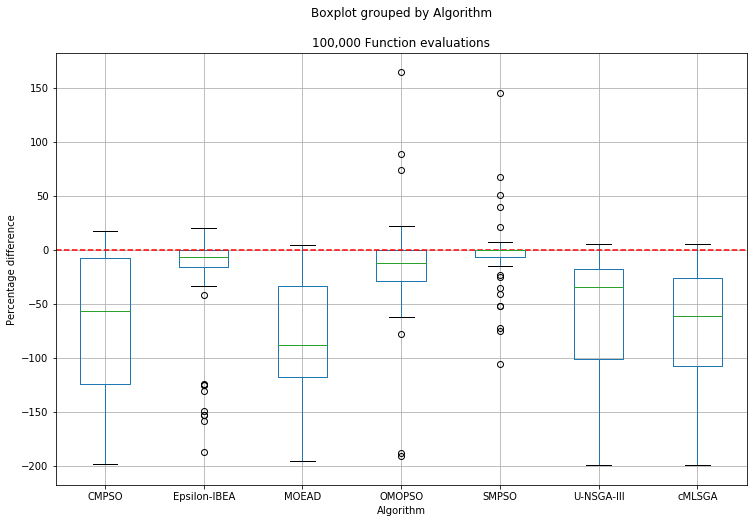

In [157]:
ax = summary_df_100k.boxplot(column=["Percentage difference"], by="Algorithm", figsize=(12,8))
ax.get_figure().gca().set_title("100,000 Function evaluations")
ax.get_figure().gca().set_ylabel("Percentage difference")
plt.axhline(0, c='r', linestyle="--")

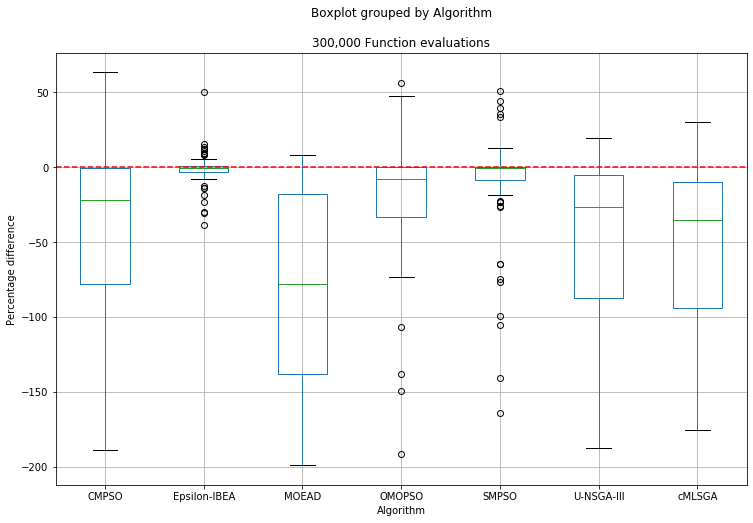

In [160]:
ax = summary_df_300k.boxplot(column=["Percentage difference"], by="Algorithm", figsize=(12,8))
ax.get_figure().gca().set_title("300,000 Function evaluations")
ax.get_figure().gca().set_ylabel("Percentage difference")
plt.axhline(0, c='r', linestyle="--")

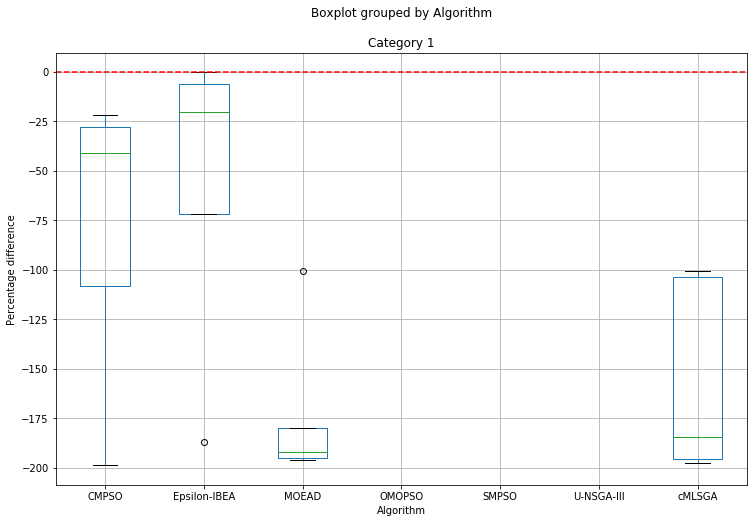

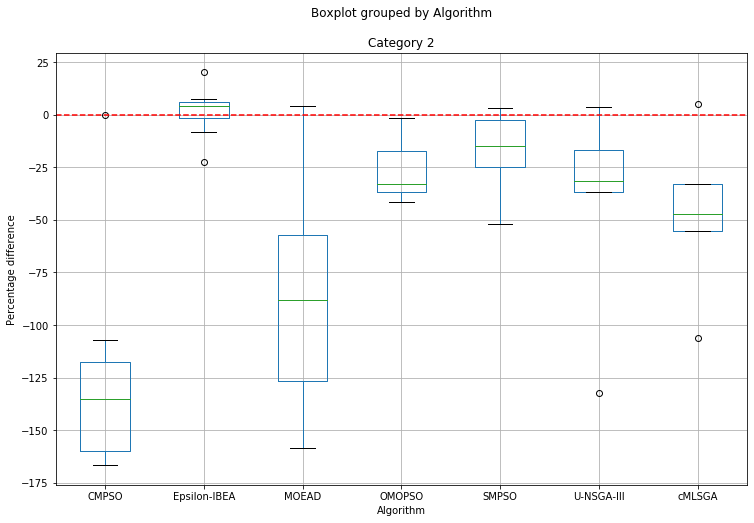

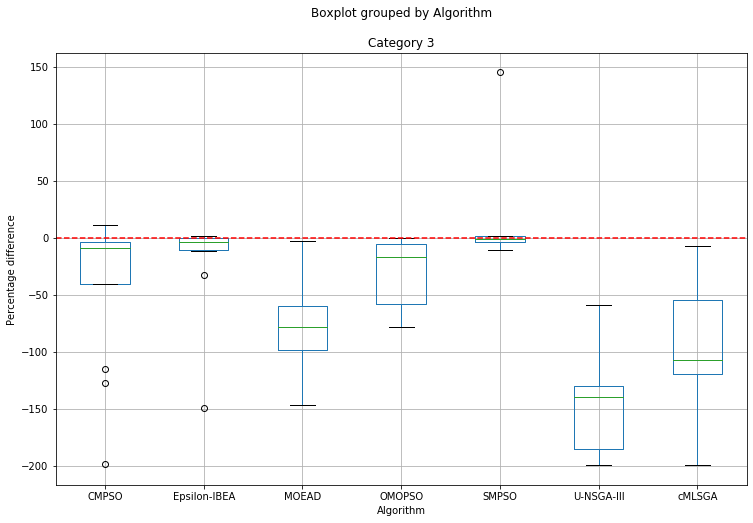

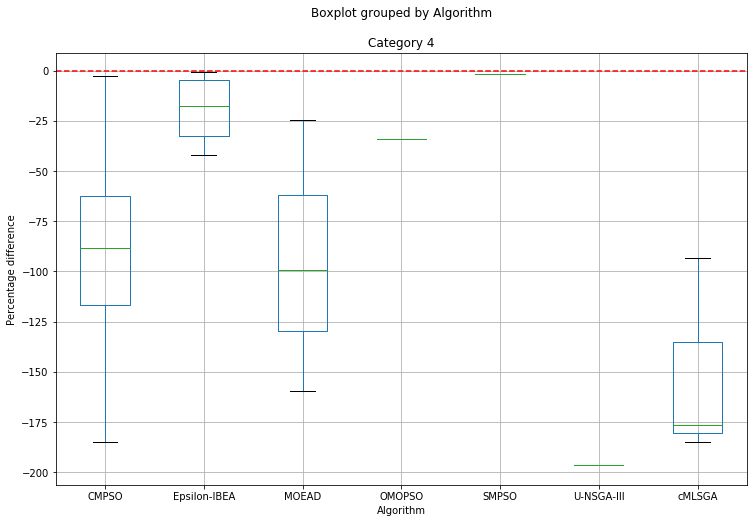

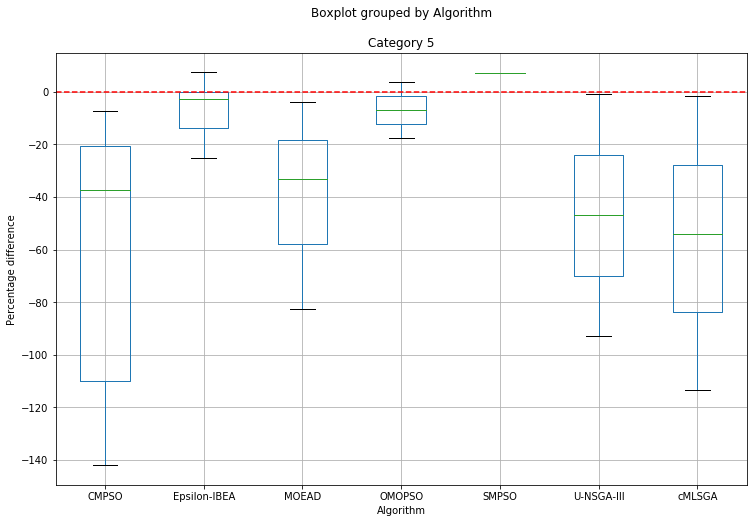

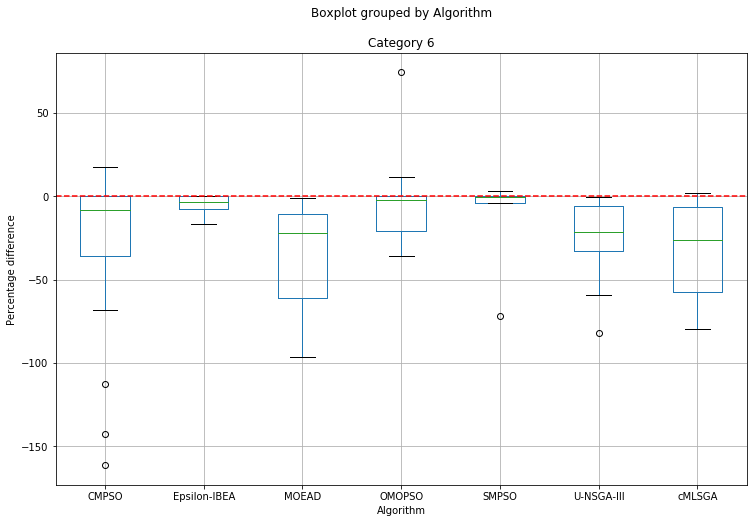

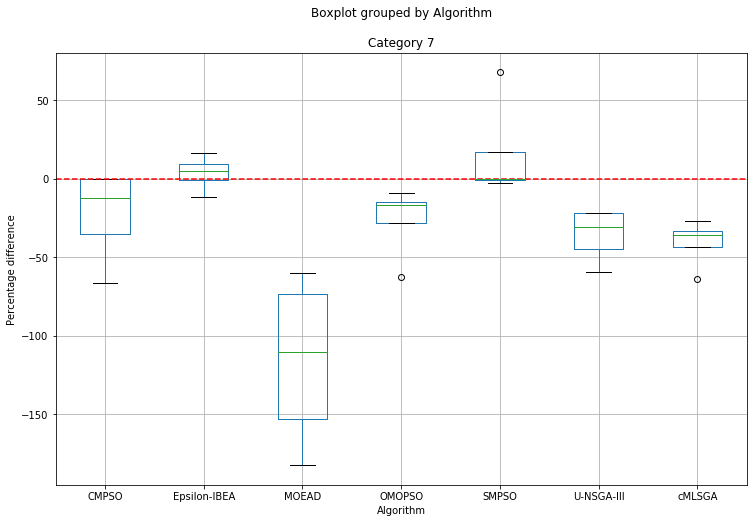

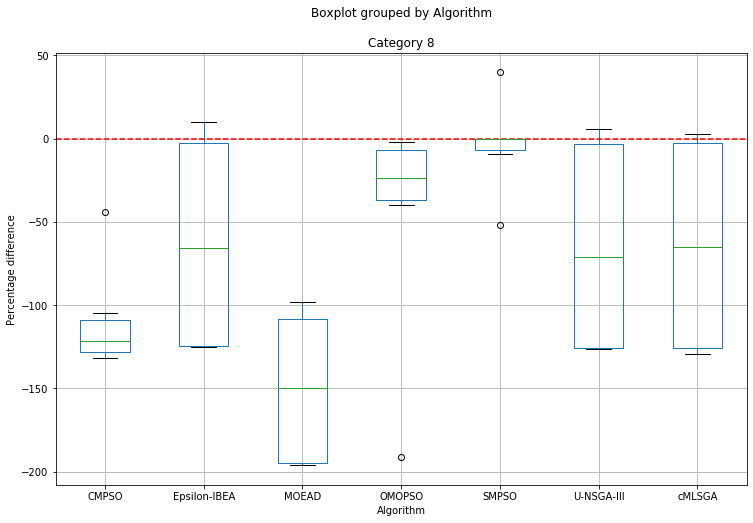

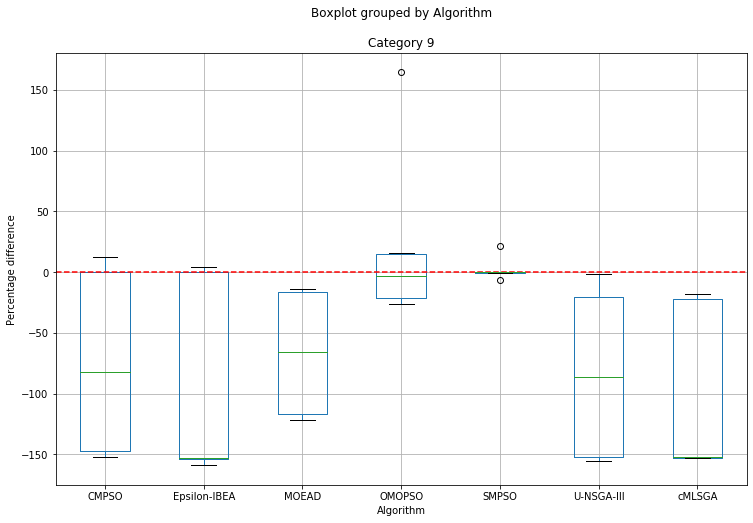

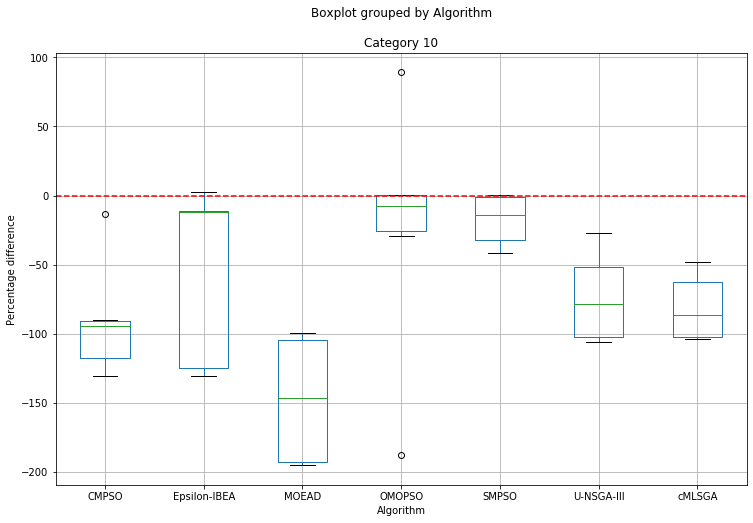

In [154]:
category_boxplots(summary_df_100k)

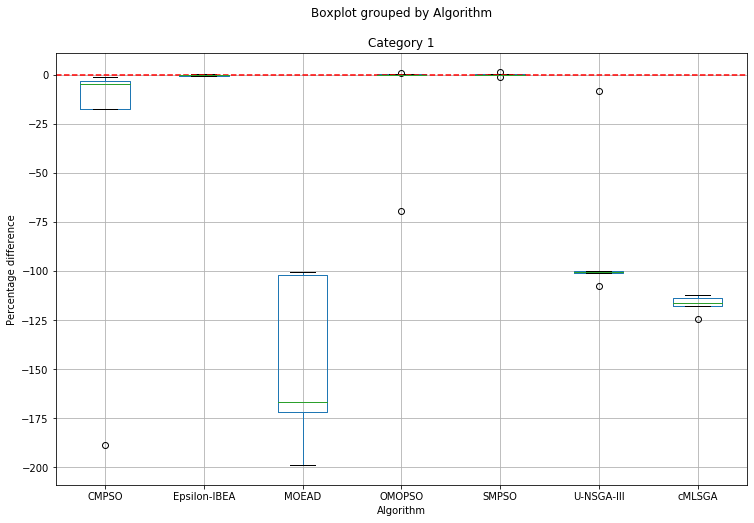

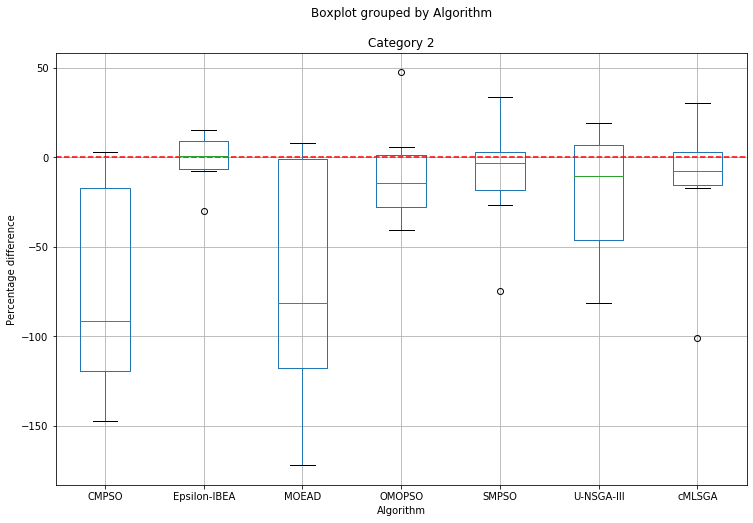

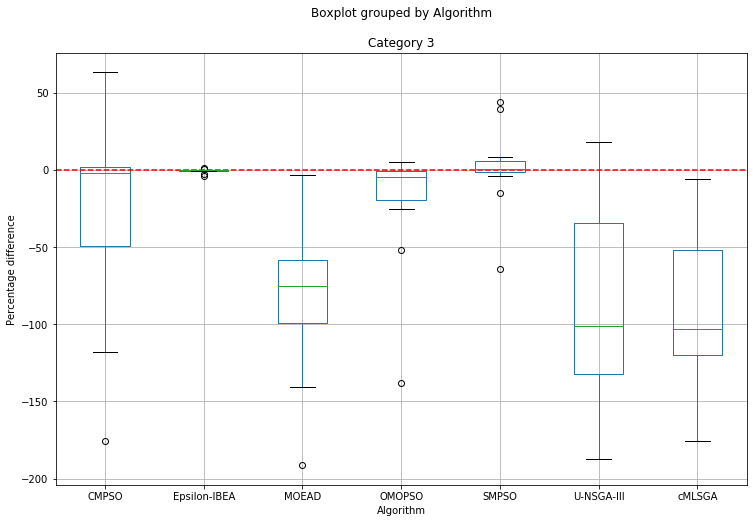

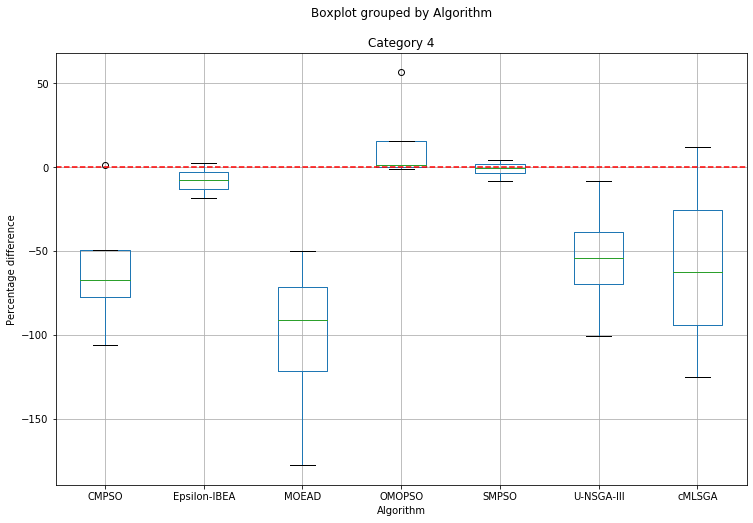

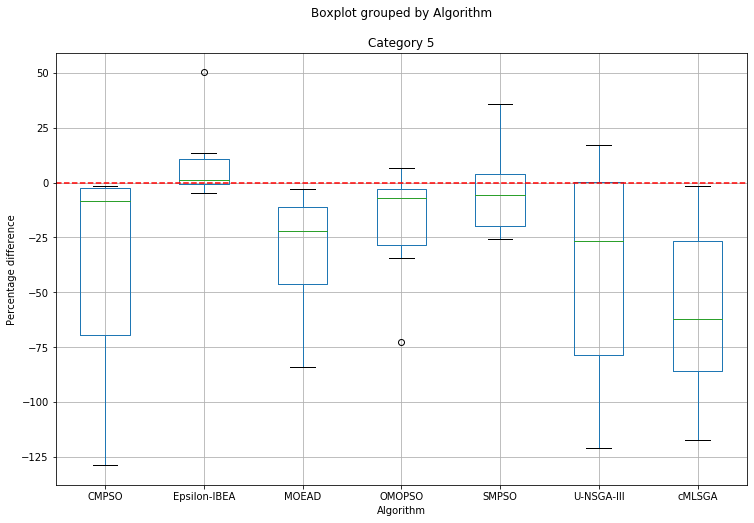

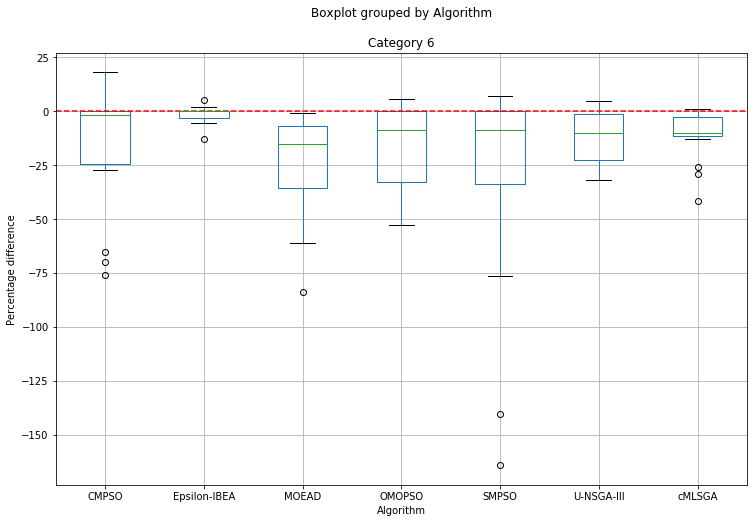

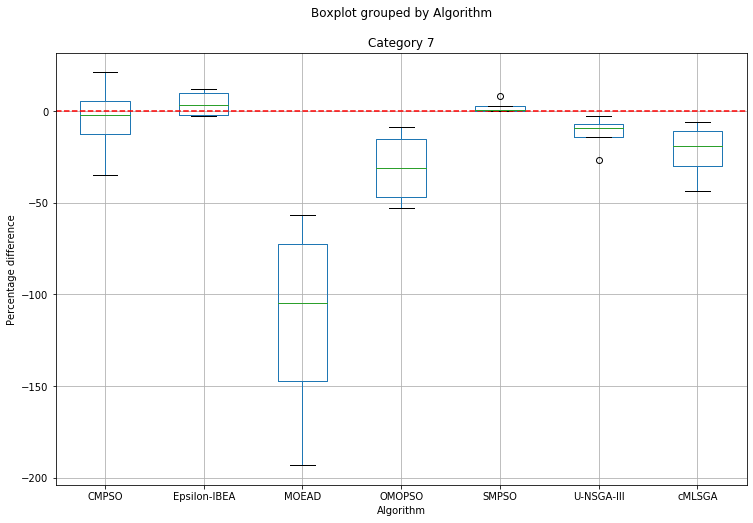

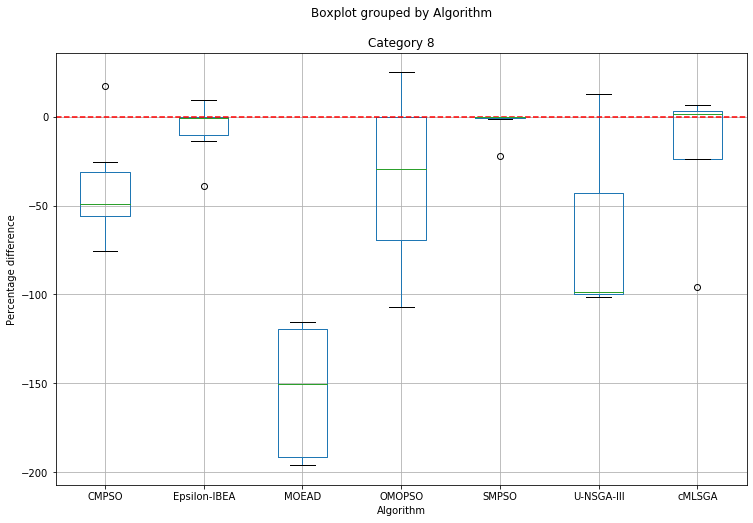

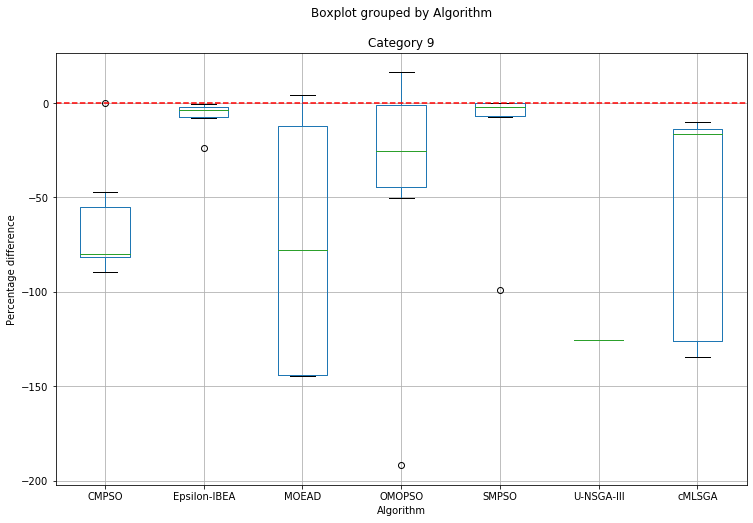

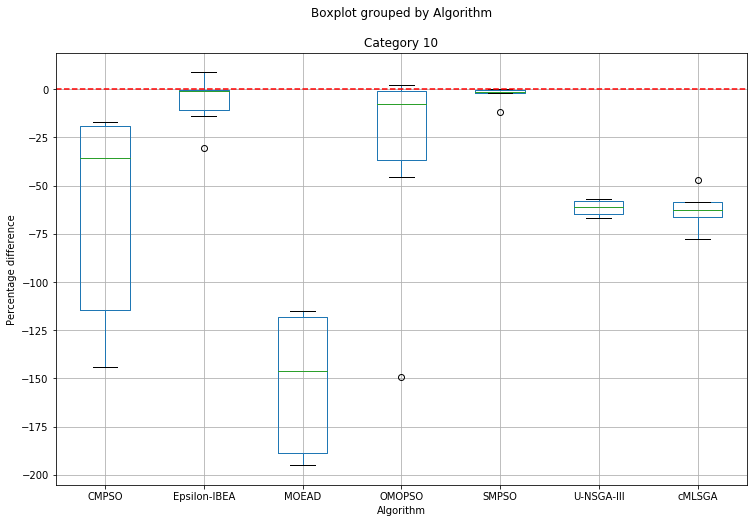

In [155]:
category_boxplots(summary_df_300k)

In [81]:
summary_df_100k_significant = create_summary_df(df_100k, df_smac_100k)
summary_df_300k_significant = create_summary_df(df_300k, df_smac_300k)

/home/sy6u19/Documents/cmlsga-jmetalpy/env3.7/lib/python3.7/site-packages/scipy/stats/stats.py:7784: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


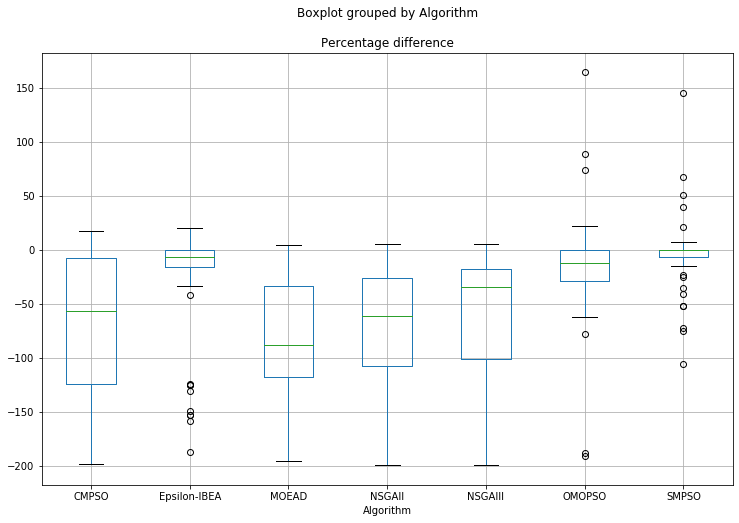

In [82]:
summary_df_100k.boxplot(column=["Percentage difference"], by="Algorithm", figsize=(12,8))

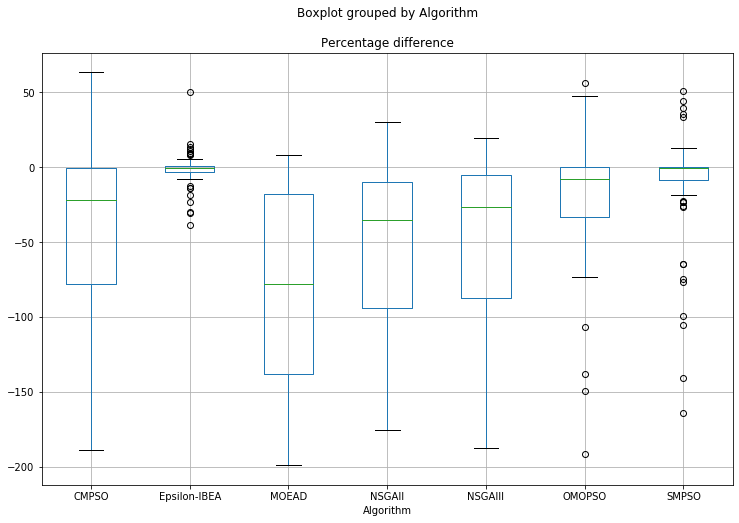

In [83]:
summary_df_300k.boxplot(column=["Percentage difference"], by="Algorithm", figsize=(12,8))

In [89]:
summary_df_100k["Problem"].unique()

array(['DASCMOP1(5)', 'DASCMOP1(6)', 'DASCMOP1(7)', 'DASCMOP2(5)',
       'DASCMOP2(6)', 'DASCMOP2(7)', 'DASCMOP3(5)', 'DASCMOP3(6)',
       'DASCMOP3(7)', 'DASCMOP4(5)', 'DASCMOP4(6)', 'DASCMOP4(7)',
       'DASCMOP5(5)', 'DASCMOP5(6)', 'DASCMOP5(7)', 'DASCMOP6(5)',
       'DASCMOP6(6)', 'DASCMOP6(7)', 'DTLZ1', 'DTLZ2', 'DTLZ3', 'DTLZ4',
       'DTLZ5', 'DTLZ6', 'DTLZ7', 'IMB1', 'IMB10', 'IMB11', 'IMB12',
       'IMB13', 'IMB14', 'IMB2', 'IMB3', 'IMB4', 'IMB5', 'IMB6', 'IMB7',
       'IMB8', 'IMB9', 'LZ09_F1', 'LZ09_F2', 'LZ09_F3', 'LZ09_F4',
       'LZ09_F5', 'LZ09_F6', 'LZ09_F7', 'LZ09_F8', 'LZ09_F9', 'MOP1',
       'MOP2', 'MOP3', 'MOP4', 'MOP5', 'MOP6', 'MOP7', 'UF1', 'UF2',
       'UF3', 'UF4', 'UF5', 'UF6', 'UF7', 'UF8', 'UF9', 'WFG1', 'WFG2',
       'WFG3', 'WFG4', 'WFG5', 'WFG6', 'WFG7', 'WFG8', 'WFG9', 'ZDT1',
       'ZDT2', 'ZDT3', 'ZDT4', 'ZDT6'], dtype=object)

In [120]:
summary_df_100k

,Algorithm,Problem,Normal IGD,SMAC IGD,p-value,Percentage difference,Category
0,CMPSO,DASCMOP1(5),0.031027,0.150753,0.000028,-131.725706,8
1,CMPSO,DASCMOP1(6),0.320901,0.282992,0.003324,12.554964,9
2,CMPSO,DASCMOP1(7),0.564283,0.646270,0.000033,-13.545309,10
3,CMPSO,DASCMOP2(5),0.035439,0.167116,0.000043,-130.015685,8
4,CMPSO,DASCMOP2(6),0.284648,0.265930,0.045606,6.799458,9
...,...,...,...,...,...,...,...
369,SMPSO,LZ09_F5,0.031484,0.040520,0.000003,-25.097725,2
370,SMPSO,LZ09_F6,0.185142,0.110249,0.000003,50.707657,0
371,SMPSO,LZ09_F7,0.080430,0.260438,0.000003,-105.617452,0
372,SMPSO,LZ09_F8,0.168067,0.368774,0.000003,-74.773587,0


In [61]:
smpso = df[(df["Algorithm"] == "SMPSO") & (df["Problem"] == "ZDT6")]["IndicatorValue"]

In [62]:
smpso_epi = df[(df["Algorithm"] == "SMPSO-epi") & (df["Problem"] == "ZDT6")]["IndicatorValue"]

In [44]:
print(wilcoxon(smpso, smpso_epi, alternative="less"))

WilcoxonResult(statistic=0.0, pvalue=0.002531016063133932)


In [71]:
for problem in problems:
    smpso = df[(df["Algorithm"] == "SMPSO") & (df["Problem"] == problem)]["IndicatorValue"]
    smpso_epi = df[(df["Algorithm"] == "SMPSO-epi") & (df["Problem"] == problem)]["IndicatorValue"]
    
    print("Problem: {}".format(problem))
    print(smpso)
    print(smpso_epi)
    print(ranksums(smpso, smpso_epi))

Problem: ZDT2
50    0.003789
51    0.003821
52    0.003756
53    0.003787
54    0.003749
55    0.003780
56    0.003791
57    0.003735
58    0.003774
59    0.003808
Name: IndicatorValue, dtype: float64
0    0.003845
1    0.003900
2    0.003898
3    0.003843
4    0.003920
5    0.003921
6    0.003911
7    0.003948
8    0.003948
9    0.003918
Name: IndicatorValue, dtype: float64
RanksumsResult(statistic=-3.779644730092272, pvalue=0.00015705228423075119)
Problem: ZDT3
60    0.004236
61    0.004254
62    0.004153
63    0.004347
64    0.004363
65    0.004250
66    0.004227
67    0.004252
68    0.004371
69    0.004381
Name: IndicatorValue, dtype: float64
10    0.004890
11    0.004776
12    0.004850
13    0.004944
14    0.004995
15    0.004941
16    0.004740
17    0.004663
18    0.004752
19    0.005105
Name: IndicatorValue, dtype: float64
RanksumsResult(statistic=-3.779644730092272, pvalue=0.00015705228423075119)
Problem: ZDT4
70    0.003677
71    0.003677
72    0.003682
73    0.003675
74    0.